# Virtually Straining a Biological Tissue with a Conditional GAN

The virtual_staining.ipynb notebook provides you with a complete code example to virtually stain a biological tissue with a conditional GAN

## Downloading the Human Motor Neurons Dataset

You’ll use a dataset that was originally published in the article: E. M. Christiansen et al., Cell 173:792-803, 2018. Specifically, you’ll use the human motor neurons dataset that is designated as “Condition A” in the article. This dataset comprises 22 pairs of brightfield and corresponding fluorescent images, with each pair including spatially registered images showcasing two fluorescent channels: Hoechst stain, revealing nuclei with a blue stain, and anti-TuJ1 stain, highlighting neurons in green. Notably, the brightfield images encompass a z-stack of 13 images across different focal planes, offering a comprehensive view of the cellular structures in question.

Download the dataset from Google Storage. The dataset is about 10 GB and will take at least a few minutes to download, or longer depending on your internet connection.

In [1]:
import os, subprocess

url = "gs://in-silico-labeling/paper_data/"
path = "virtual_staining_dataset"
if not os.path.exists(path):
    for dataset in ["train", "test"]:
        dataset_url = url + dataset + "/Rubin/scott_1_0"
        dataset_dir = os.path.join(path, dataset)
        os.makedirs(dataset_dir, exist_ok=True)
        
        command = ["gsutil", "-m", "cp", "-r", dataset_url, dataset_dir]
        subprocess.run(command, check=True)

## Creating a Dataset

Implement a class containing the dataset ...

In [2]:
import glob
import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset
from tqdm import tqdm

class VirtualStainingDataset(Dataset):
    """Dataset containing the brighfield and fluorescence images."""

    _cache = {}  # Class variable to cache loaded images.

    def __init__(self, directory, transform=None, preload=False):
        """Initialize dataset."""
        self.transform = transform
        self.preload = preload
        self.images = []

        self.image_dir = os.path.join(directory, "scott_1_0")
        pattern = ("lab-Rubin,condition-scott_1_0,acquisition_date,"
                   "year-2016,month-2,day-6,"
                   "well-r0*c0*,"
                   "depth_computation,"
                   "value-MAXPROJECT,is_mask-false,kind,value-ORIGINAL.png")   
        self.image_list = glob.glob(os.path.join(self.image_dir, pattern))

        self.cache_key = self.image_dir
        if self.preload:
            if self.cache_key in VirtualStainingDataset._cache:
                self.images = VirtualStainingDataset._cache[self.cache_key]
            else:
                for image_path in tqdm(self.image_list,
                                       total=len(self.image_list),
                                       desc="Preloading images"):
                    self.images.append(self.load_image(image_path))
                VirtualStainingDataset._cache[self.cache_key] = self.images

    def __len__(self):
        """Return number of images."""
        return len(self.image_list)

    def __getitem__(self, idx):
        """Get next input-target image couple."""
        if self.preload:
            input_image, target_image = self.images[idx]
        else:
            input_image, target_image = self.load_image(self.image_list[idx])

        if self.transform:
            seed = np.random.randint(1_000_000_000)
            
            torch.manual_seed(seed)
            input_image = self.transform[0](input_image)

            torch.manual_seed(seed)
            target_image = self.transform[1](target_image)

        return input_image, target_image

    def load_image(self, image_path):
        """Load input-target image couple."""
        input_image = []
        for i in range(0, 13):
            img_path = (image_path
                        .replace("depth_computation", f"z_depth-{i},channel")
                        .replace("value-MAXPROJECT", "value-BRIGHTFIELD"))
            input_image.append(np.array(Image.open(img_path).convert("L")))
        input_image = np.stack(input_image, axis=-1)

        target_image = np.array(Image.open(image_path))

        return input_image, target_image

... define the image transformations and normalizations ...

In [3]:
from torchvision import transforms

trans_bright = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomCrop((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Normalize(mean=[0.5] * 13, std=[0.5] * 13)
])
trans_fluorescent = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomCrop((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)
])

... create the training and testing datasets ...

In [4]:
train_dataset = VirtualStainingDataset(
    directory=os.path.join(path, "train"),
    transform=[trans_bright, trans_fluorescent],
    preload=True,
)
test_dataset = VirtualStainingDataset(
    directory=os.path.join(path, "test"),
    transform=[trans_bright, trans_fluorescent],
    preload=True,
)

Preloading images: 100%|██████████| 3/3 [00:12<00:00,  4.15s/it]


... and visualize brightfield and corresponding fluorescence images.

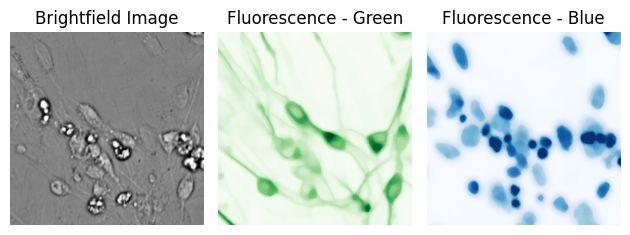

In [5]:
import matplotlib.pyplot as plt

bf_img, fl_img = train_dataset[np.random.randint(0, len(train_dataset))]

def denormalize(image):
    """Denormalize images for visualization."""
    return (image + 1) / 2

plt.figure()

plt.subplot(1, 3, 1)
plt.imshow(bf_img.mean(axis=0), cmap="gray")
plt.title("Brightfield Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(denormalize(fl_img[1, :, :].numpy()), cmap="Greens")
plt.title("Fluorescence - Green")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(denormalize(fl_img[2, :, :].numpy()), cmap="Blues")
plt.title("Fluorescence - Blue")
plt.axis("off")

plt.tight_layout()
plt.show()

## Instantiating the Generator and Discriminator

Determine the device to be used in the computations ...

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

... define the generator ...

In [7]:
import deeplay as dl
import torch.nn as nn

generator = dl.UNet2d(
    in_channels=13,
    channels=[32, 64, 128, 256, 512],
    out_channels=3,
)
generator["encoder", ..., "activation"] \
    .configure(nn.LeakyReLU, negative_slope=0.2)
generator["decoder", ..., "activation#:-1"] \
    .configure(nn.LeakyReLU, negative_slope=0.2)
generator["decoder", ..., "activation#-1"].configure(nn.Tanh)
generator["decoder", "blocks", :-1].all.normalized(nn.InstanceNorm2d)
generator[..., "blocks"] \
    .configure(order=["layer", "normalization", "activation"])
generator.build()
generator.to(device);

print(generator)

UNet2d(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (layer): Conv2d(13, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (1): Conv2dBlock(
        (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (2): Conv2dBlock(
        (layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (3): Conv2dBlock(
        (layer): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (4): Conv2dBlock(
        (layer): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
    )
    (postprocess): Identity()
  )
  (bottleneck): ConvolutionalNeuralNetwork(
    (b

... and define the discriminator.

In [8]:
discriminator = dl.ConvolutionalNeuralNetwork(
    in_channels=16,
    hidden_channels=[8, 16, 32, 64],
    out_channels=1,
)
discriminator["blocks", ..., "layer"] \
    .configure(kernel_size=4, stride=2, padding=1)
discriminator["blocks", ..., "activation#:-1"] \
    .configure(nn.LeakyReLU, negative_slope=0.2)
discriminator["blocks", 1:-1].all.normalized(nn.InstanceNorm2d)
discriminator["blocks", ..., "activation#-1"].configure(nn.Sigmoid)
discriminator["blocks"] \
    .configure(order=["layer", "normalization", "activation"])
discriminator.build()
discriminator.to(device);

print(discriminator)

ConvolutionalNeuralNetwork(
  (blocks): LayerList(
    (0): Conv2dBlock(
      (layer): Conv2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (activation): LeakyReLU(negative_slope=0.2)
    )
    (1): Conv2dBlock(
      (layer): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (normalization): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (activation): LeakyReLU(negative_slope=0.2)
    )
    (2): Conv2dBlock(
      (layer): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (normalization): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (activation): LeakyReLU(negative_slope=0.2)
    )
    (3): Conv2dBlock(
      (layer): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (normalization): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (activation): LeakyReLU(negative_slope=0.

## Compiling the Conditional GAN

Define the losses ...

In [9]:
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

loss_D = torch.nn.MSELoss()
loss_G = torch.nn.L1Loss()
loss_LPIPS = LearnedPerceptualImagePatchSimilarity(net_type="vgg").to(device)

... define the optimizers ...

In [10]:
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002,
                                       betas=(0.5, 0.999))
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(),
                                           lr=0.00005, betas=(0.5, 0.999))

... and define the data loaders.

In [11]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, 
                                          shuffle=True)

## Training the Conditional GAN

Define a function to train the discriminator ...

In [12]:
def train_discriminator(inputs, targets, optimizer, loss_D=loss_D):
    """Train the discriminator."""
    generator.train()
    optimizer.zero_grad()

    # Compute real loss.
    output_real = discriminator(torch.cat([inputs, targets], dim=1))
    label_real = torch.ones_like(output_real)
    loss_real = loss_D(output_real, label_real)

    # Compute fake loss.
    output_fake = discriminator(torch.cat([inputs, generator(inputs)], dim=1))
    label_fake = torch.zeros_like(output_fake)
    loss_fake = loss_D(output_fake, label_fake)

    loss = (loss_real + loss_fake) / 2
    loss.backward()
    optimizer.step()
    
    return loss

... define a function to train the generator ...

In [13]:
def train_generator(inputs, targets, optimizer, loss_D=loss_D, loss_G=loss_G,
                    loss_LPIPS=loss_LPIPS, L1_Lambda=100, LPIPS_Lambda=10):
    """Train the generator."""
    optimizer.zero_grad()

    generator_output = generator(inputs)
    discriminator_output = discriminator(torch.cat([inputs, generator_output], 
                                                    dim=1))
    
    label = torch.ones_like(discriminator_output)
    loss_GAN = loss_D(discriminator_output, label)
    loss_L1 = loss_G(generator_output, targets)
    loss_P = loss_LPIPS(generator_output, targets)
    
    loss = loss_GAN + L1_Lambda * loss_L1 + LPIPS_Lambda * loss_P
    loss.backward()
    optimizer.step()

    return loss_GAN, loss_L1, loss_P


... and a function to evaluate the model on the test dataset ...

In [14]:
def evaluate_model(image, label):
    """Evaluate model on test data."""
    generator.eval()
    with torch.no_grad():
        prediction = generator(image)

    fig, ax = plt.subplots(2, 3, figsize=(10, 5))

    ax[0, 0].imshow(
        denormalize(image[0].permute(1, 2, 0).cpu().numpy().mean(axis=-1)), 
        cmap="gray"
    )
    ax[0, 0].axis("off")
    ax[0, 0].set_title("Input Image")

    ax[0, 1].imshow(
        denormalize(prediction[0].permute(1, 2, 0).cpu().numpy())[:, :, 1], 
        cmap="Greens",
    )
    ax[0, 1].axis("off")
    ax[0, 1].set_title("Prediction - Green")

    ax[1, 1].imshow(
        denormalize(label[0].permute(1, 2, 0).cpu().numpy())[:, :, 1], 
        cmap="Greens",
    )
    ax[1, 1].axis("off")
    ax[1, 1].set_title("Ground truth - Green")

    ax[0, 2].imshow(
        denormalize(prediction[0].permute(1, 2, 0).cpu().numpy())[:, :, 2], 
        cmap="Blues",
    )
    ax[0, 2].axis("off")
    ax[0, 2].set_title("Prediction - Blue")

    ax[1, 2].imshow(
        denormalize(label[0].permute(1, 2, 0).cpu().numpy())[:, :, 2], 
        cmap="Blues",
    )
    ax[1, 2].axis("off")
    ax[1, 2].set_title("Ground truth - Blue")

    ax[1, 0].axis("off")  # Leave the [1, 0] subplot empty.

    plt.tight_layout()
    plt.show()
    plt.close(fig)

... and implement the training cycle.


Epoch 1/500
----------
Batch 1/11 : Generator Loss: 1.6103, Discriminator Loss: 0.2582
Batch 6/11 : Generator Loss: 1.1900, Discriminator Loss: 0.2578
Batch 11/11 : Generator Loss: 1.0431, Discriminator Loss: 0.2563
----------
Epoch 1/500 : Generator loss: 0.2573, Discriminator Loss: 0.2575, Reconstruction Loss: 0.4071, Perception loss: 0.5663
Time taken: 0:00:53.614450


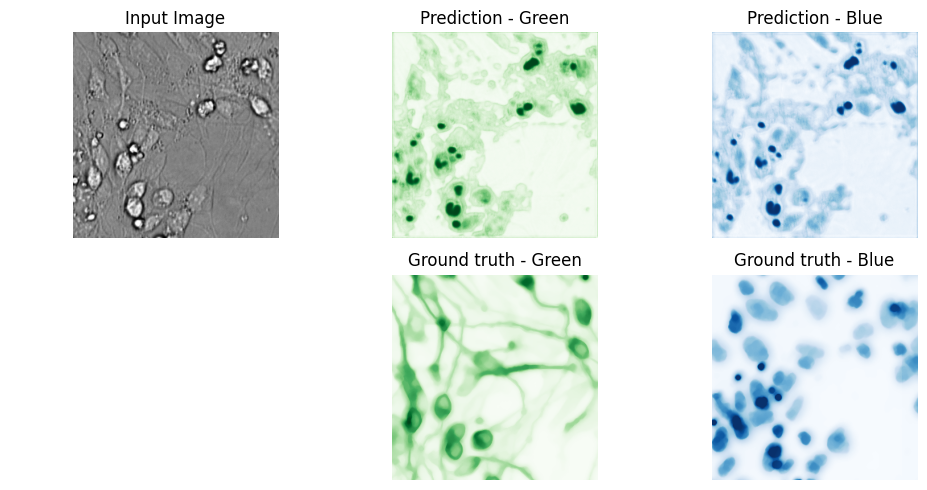


Epoch 2/500
----------
Batch 1/11 : Generator Loss: 1.0278, Discriminator Loss: 0.2573
Batch 6/11 : Generator Loss: 0.9267, Discriminator Loss: 0.2548
Batch 11/11 : Generator Loss: 0.9064, Discriminator Loss: 0.2545
----------
Epoch 2/500 : Generator loss: 0.2539, Discriminator Loss: 0.2565, Reconstruction Loss: 0.1938, Perception loss: 0.4826
Time taken: 0:00:54.207199

Epoch 3/500
----------
Batch 1/11 : Generator Loss: 0.8419, Discriminator Loss: 0.2536
Batch 6/11 : Generator Loss: 0.8066, Discriminator Loss: 0.2524
Batch 11/11 : Generator Loss: 0.7924, Discriminator Loss: 0.2553
----------
Epoch 3/500 : Generator loss: 0.2532, Discriminator Loss: 0.2552, Reconstruction Loss: 0.1300, Perception loss: 0.4385
Time taken: 0:00:53.177899

Epoch 4/500
----------
Batch 1/11 : Generator Loss: 0.8473, Discriminator Loss: 0.2582
Batch 6/11 : Generator Loss: 0.7571, Discriminator Loss: 0.2545
Batch 11/11 : Generator Loss: 0.8013, Discriminator Loss: 0.2540
----------
Epoch 4/500 : Generator 

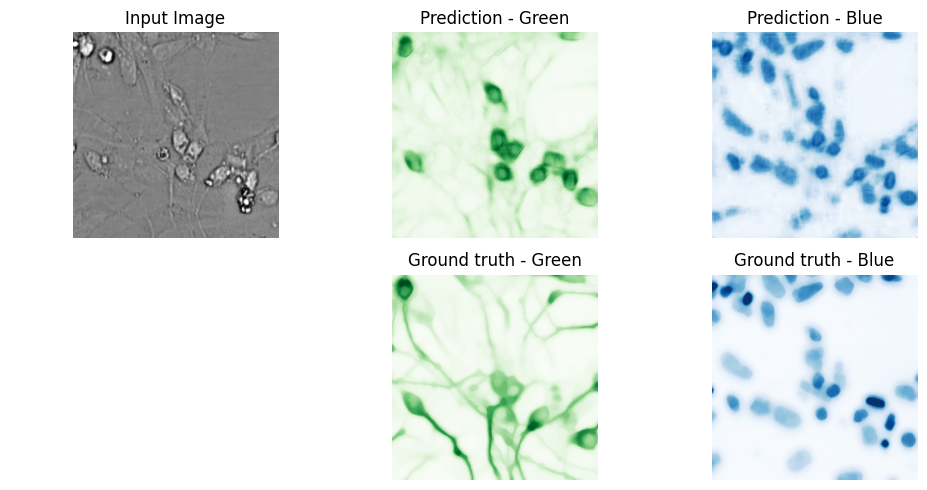


Epoch 52/500
----------
Batch 1/11 : Generator Loss: 0.6249, Discriminator Loss: 0.2504
Batch 6/11 : Generator Loss: 0.5971, Discriminator Loss: 0.2505
Batch 11/11 : Generator Loss: 0.6388, Discriminator Loss: 0.2502
----------
Epoch 52/500 : Generator loss: 0.2517, Discriminator Loss: 0.2505, Reconstruction Loss: 0.0589, Perception loss: 0.3022
Time taken: 0:00:48.518923

Epoch 53/500
----------
Batch 1/11 : Generator Loss: 0.5585, Discriminator Loss: 0.2502
Batch 6/11 : Generator Loss: 0.6187, Discriminator Loss: 0.2505
Batch 11/11 : Generator Loss: 0.6178, Discriminator Loss: 0.2507
----------
Epoch 53/500 : Generator loss: 0.2504, Discriminator Loss: 0.2506, Reconstruction Loss: 0.0616, Perception loss: 0.3106
Time taken: 0:00:48.401840

Epoch 54/500
----------
Batch 1/11 : Generator Loss: 0.6367, Discriminator Loss: 0.2513
Batch 6/11 : Generator Loss: 0.6334, Discriminator Loss: 0.2494
Batch 11/11 : Generator Loss: 0.6484, Discriminator Loss: 0.2509
----------
Epoch 54/500 : Gene

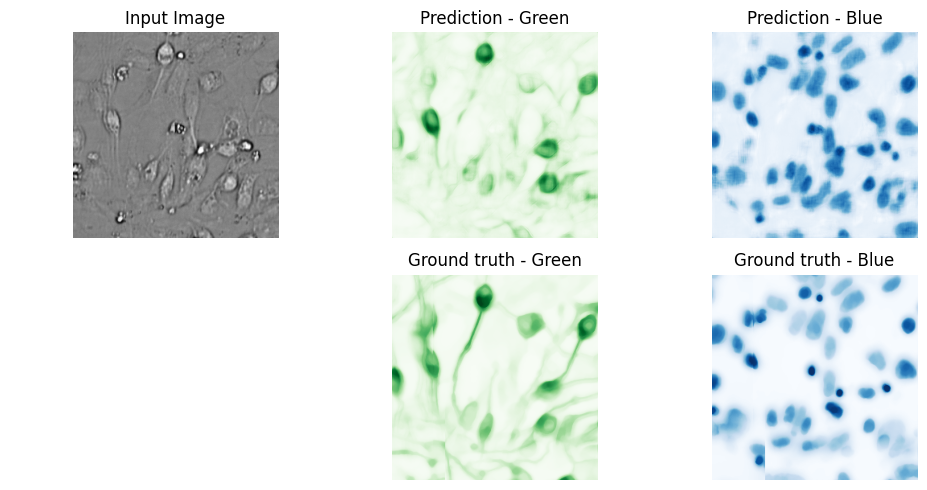


Epoch 102/500
----------
Batch 1/11 : Generator Loss: 0.7495, Discriminator Loss: 0.1947
Batch 6/11 : Generator Loss: 0.6903, Discriminator Loss: 0.1695
Batch 11/11 : Generator Loss: 0.5725, Discriminator Loss: 0.3168
----------
Epoch 102/500 : Generator loss: 0.3398, Discriminator Loss: 0.1946, Reconstruction Loss: 0.0547, Perception loss: 0.2725
Time taken: 0:00:52.709902

Epoch 103/500
----------
Batch 1/11 : Generator Loss: 0.5180, Discriminator Loss: 0.1562
Batch 6/11 : Generator Loss: 0.6354, Discriminator Loss: 0.1566
Batch 11/11 : Generator Loss: 0.7262, Discriminator Loss: 0.2573
----------
Epoch 103/500 : Generator loss: 0.3343, Discriminator Loss: 0.1958, Reconstruction Loss: 0.0595, Perception loss: 0.2893
Time taken: 0:00:52.596505

Epoch 104/500
----------
Batch 1/11 : Generator Loss: 0.7054, Discriminator Loss: 0.1958
Batch 6/11 : Generator Loss: 0.7268, Discriminator Loss: 0.2263
Batch 11/11 : Generator Loss: 0.8642, Discriminator Loss: 0.1735
----------
Epoch 104/500 

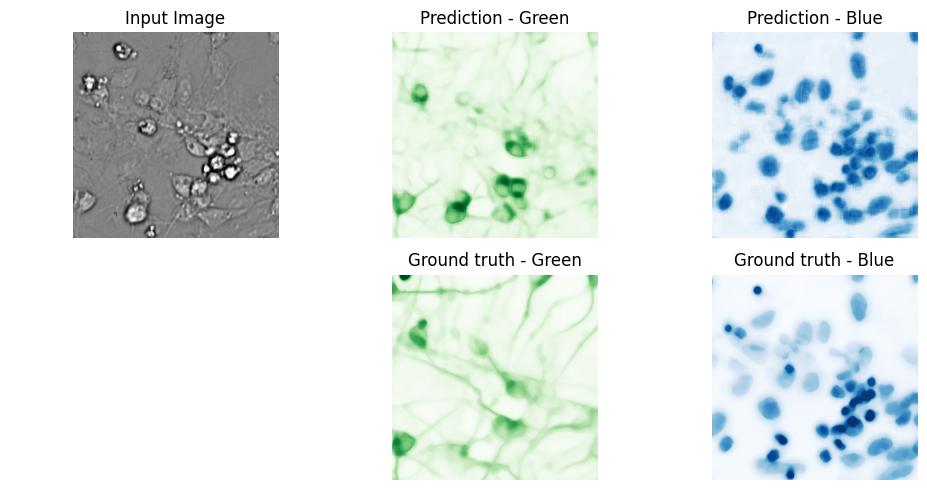


Epoch 152/500
----------
Batch 1/11 : Generator Loss: 0.6365, Discriminator Loss: 0.1828
Batch 6/11 : Generator Loss: 0.7711, Discriminator Loss: 0.1571
Batch 11/11 : Generator Loss: 0.5414, Discriminator Loss: 0.1908
----------
Epoch 152/500 : Generator loss: 0.3334, Discriminator Loss: 0.1989, Reconstruction Loss: 0.0538, Perception loss: 0.2646
Time taken: 0:00:52.707384

Epoch 153/500
----------
Batch 1/11 : Generator Loss: 0.9933, Discriminator Loss: 0.4005
Batch 6/11 : Generator Loss: 0.7056, Discriminator Loss: 0.1536
Batch 11/11 : Generator Loss: 0.7944, Discriminator Loss: 0.1212
----------
Epoch 153/500 : Generator loss: 0.3906, Discriminator Loss: 0.1981, Reconstruction Loss: 0.0570, Perception loss: 0.2820
Time taken: 0:00:52.557420

Epoch 154/500
----------
Batch 1/11 : Generator Loss: 0.7495, Discriminator Loss: 0.2435
Batch 6/11 : Generator Loss: 0.7466, Discriminator Loss: 0.1956
Batch 11/11 : Generator Loss: 0.6825, Discriminator Loss: 0.1200
----------
Epoch 154/500 

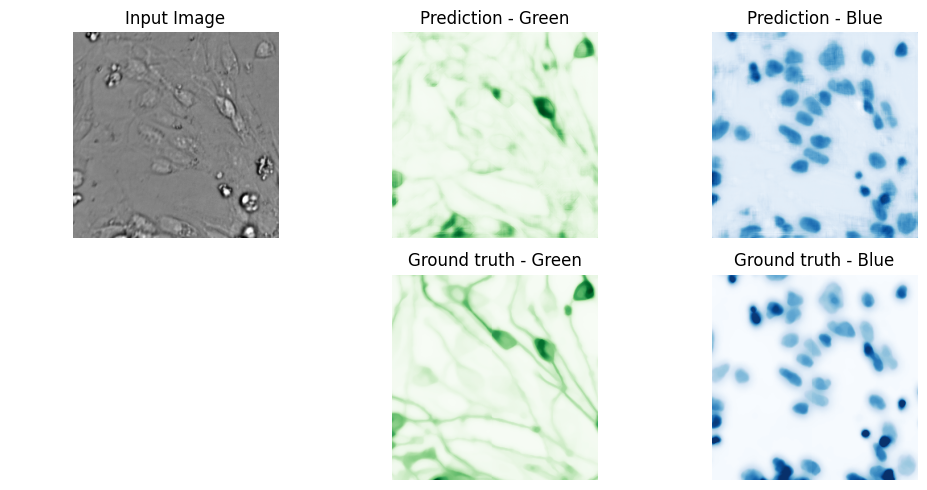


Epoch 202/500
----------
Batch 1/11 : Generator Loss: 0.6604, Discriminator Loss: 0.1640
Batch 6/11 : Generator Loss: 0.7818, Discriminator Loss: 0.1578
Batch 11/11 : Generator Loss: 0.4573, Discriminator Loss: 0.3115
----------
Epoch 202/500 : Generator loss: 0.3002, Discriminator Loss: 0.2042, Reconstruction Loss: 0.0562, Perception loss: 0.2691
Time taken: 0:00:48.587796

Epoch 203/500
----------
Batch 1/11 : Generator Loss: 0.6925, Discriminator Loss: 0.2509
Batch 6/11 : Generator Loss: 0.5086, Discriminator Loss: 0.2557
Batch 11/11 : Generator Loss: 0.7539, Discriminator Loss: 0.1969
----------
Epoch 203/500 : Generator loss: 0.3884, Discriminator Loss: 0.2048, Reconstruction Loss: 0.0530, Perception loss: 0.2636
Time taken: 0:00:48.598920

Epoch 204/500
----------
Batch 1/11 : Generator Loss: 0.7212, Discriminator Loss: 0.2415
Batch 6/11 : Generator Loss: 0.7715, Discriminator Loss: 0.2014
Batch 11/11 : Generator Loss: 0.5740, Discriminator Loss: 0.1871
----------
Epoch 204/500 

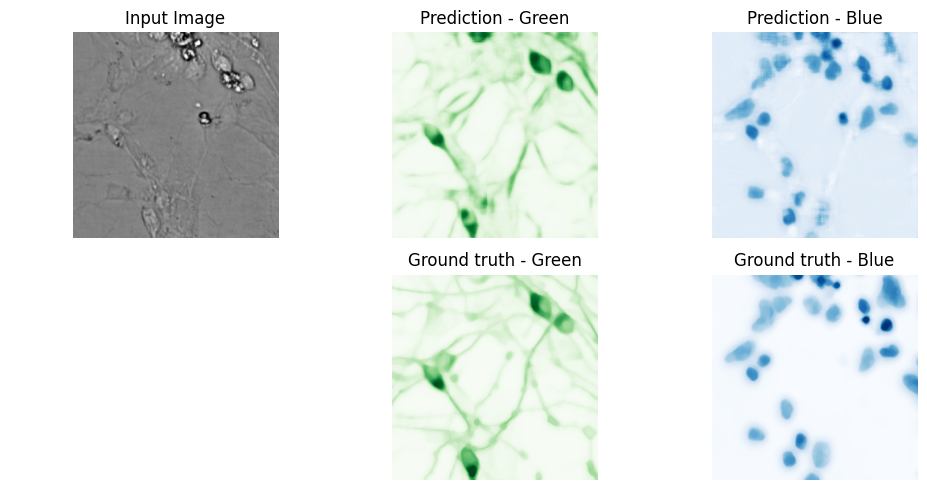


Epoch 252/500
----------
Batch 1/11 : Generator Loss: 0.7307, Discriminator Loss: 0.2582
Batch 6/11 : Generator Loss: 0.7473, Discriminator Loss: 0.1746
Batch 11/11 : Generator Loss: 0.7405, Discriminator Loss: 0.2945
----------
Epoch 252/500 : Generator loss: 0.3905, Discriminator Loss: 0.2225, Reconstruction Loss: 0.0551, Perception loss: 0.2631
Time taken: 0:00:48.581103

Epoch 253/500
----------
Batch 1/11 : Generator Loss: 0.7721, Discriminator Loss: 0.0627
Batch 6/11 : Generator Loss: 0.6564, Discriminator Loss: 0.2310
Batch 11/11 : Generator Loss: 0.5903, Discriminator Loss: 0.1882
----------
Epoch 253/500 : Generator loss: 0.3710, Discriminator Loss: 0.1890, Reconstruction Loss: 0.0544, Perception loss: 0.2516
Time taken: 0:00:48.531594

Epoch 254/500
----------
Batch 1/11 : Generator Loss: 0.7188, Discriminator Loss: 0.2647
Batch 6/11 : Generator Loss: 0.6396, Discriminator Loss: 0.1285
Batch 11/11 : Generator Loss: 0.6820, Discriminator Loss: 0.1301
----------
Epoch 254/500 

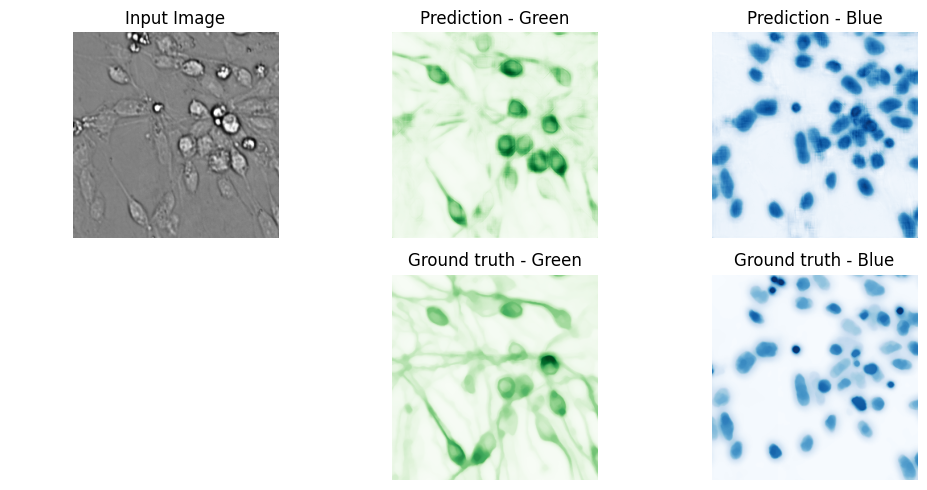


Epoch 302/500
----------
Batch 1/11 : Generator Loss: 0.5567, Discriminator Loss: 0.2041
Batch 6/11 : Generator Loss: 0.6062, Discriminator Loss: 0.2213
Batch 11/11 : Generator Loss: 0.8577, Discriminator Loss: 0.0654
----------
Epoch 302/500 : Generator loss: 0.3923, Discriminator Loss: 0.1964, Reconstruction Loss: 0.0536, Perception loss: 0.2532
Time taken: 0:00:48.593825

Epoch 303/500
----------
Batch 1/11 : Generator Loss: 0.7342, Discriminator Loss: 0.2404
Batch 6/11 : Generator Loss: 0.6216, Discriminator Loss: 0.2238
Batch 11/11 : Generator Loss: 0.7448, Discriminator Loss: 0.2613
----------
Epoch 303/500 : Generator loss: 0.3224, Discriminator Loss: 0.2010, Reconstruction Loss: 0.0536, Perception loss: 0.2573
Time taken: 0:00:48.491115

Epoch 304/500
----------
Batch 1/11 : Generator Loss: 0.8111, Discriminator Loss: 0.2127
Batch 6/11 : Generator Loss: 0.8199, Discriminator Loss: 0.1598
Batch 11/11 : Generator Loss: 0.7957, Discriminator Loss: 0.1504
----------
Epoch 304/500 

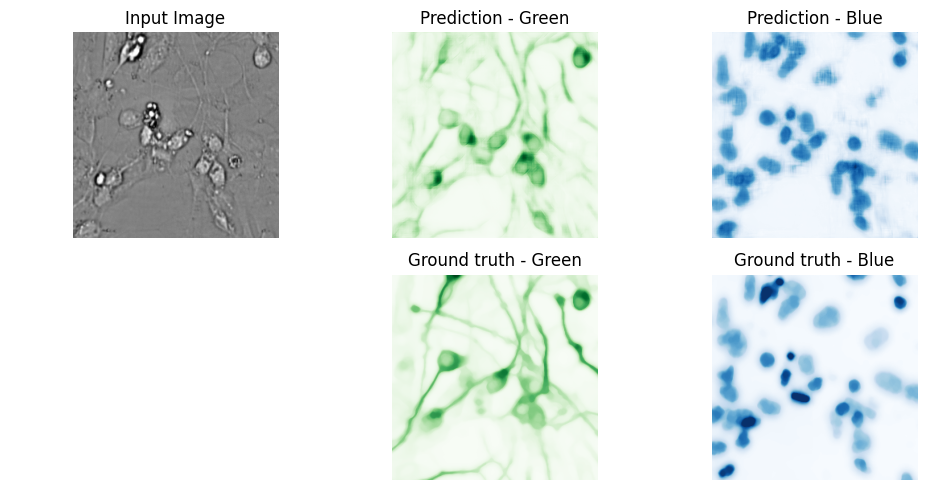


Epoch 352/500
----------
Batch 1/11 : Generator Loss: 0.7417, Discriminator Loss: 0.1018
Batch 6/11 : Generator Loss: 0.6832, Discriminator Loss: 0.1605
Batch 11/11 : Generator Loss: 0.7708, Discriminator Loss: 0.1689
----------
Epoch 352/500 : Generator loss: 0.3757, Discriminator Loss: 0.1779, Reconstruction Loss: 0.0536, Perception loss: 0.2633
Time taken: 0:00:48.518992

Epoch 353/500
----------
Batch 1/11 : Generator Loss: 0.6158, Discriminator Loss: 0.1209
Batch 6/11 : Generator Loss: 0.9762, Discriminator Loss: 0.1959
Batch 11/11 : Generator Loss: 0.7548, Discriminator Loss: 0.1262
----------
Epoch 353/500 : Generator loss: 0.3610, Discriminator Loss: 0.1805, Reconstruction Loss: 0.0572, Perception loss: 0.2623
Time taken: 0:00:48.484027

Epoch 354/500
----------
Batch 1/11 : Generator Loss: 0.5624, Discriminator Loss: 0.1793
Batch 6/11 : Generator Loss: 0.5513, Discriminator Loss: 0.1683
Batch 11/11 : Generator Loss: 0.6200, Discriminator Loss: 0.1177
----------
Epoch 354/500 

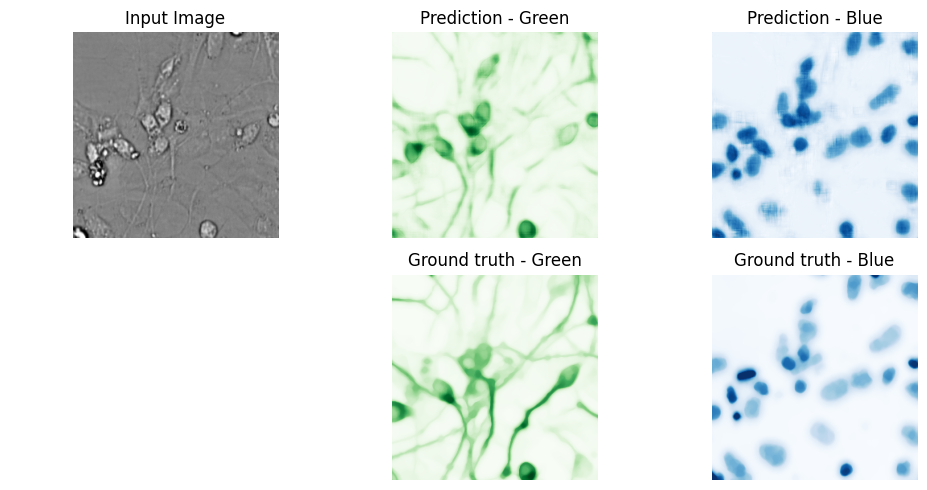


Epoch 402/500
----------
Batch 1/11 : Generator Loss: 0.7684, Discriminator Loss: 0.1486
Batch 6/11 : Generator Loss: 0.8481, Discriminator Loss: 0.0622
Batch 11/11 : Generator Loss: 0.5097, Discriminator Loss: 0.2110
----------
Epoch 402/500 : Generator loss: 0.3651, Discriminator Loss: 0.1786, Reconstruction Loss: 0.0546, Perception loss: 0.2591
Time taken: 0:00:48.610312

Epoch 403/500
----------
Batch 1/11 : Generator Loss: 0.8091, Discriminator Loss: 0.1425
Batch 6/11 : Generator Loss: 0.4780, Discriminator Loss: 0.1874
Batch 11/11 : Generator Loss: 0.5437, Discriminator Loss: 0.2325
----------
Epoch 403/500 : Generator loss: 0.3830, Discriminator Loss: 0.1867, Reconstruction Loss: 0.0526, Perception loss: 0.2635
Time taken: 0:00:48.483397

Epoch 404/500
----------
Batch 1/11 : Generator Loss: 0.4535, Discriminator Loss: 0.2427
Batch 6/11 : Generator Loss: 0.7620, Discriminator Loss: 0.0621
Batch 11/11 : Generator Loss: 0.6061, Discriminator Loss: 0.2002
----------
Epoch 404/500 

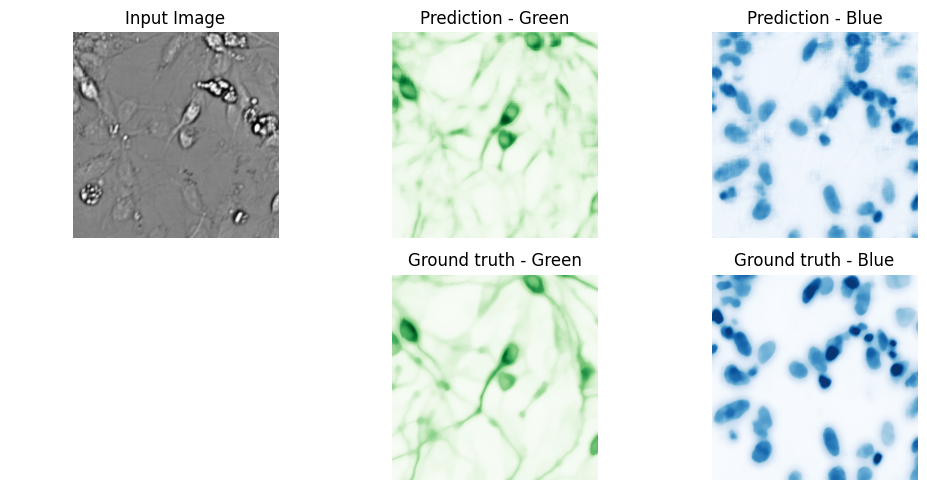


Epoch 452/500
----------
Batch 1/11 : Generator Loss: 0.4997, Discriminator Loss: 0.2633
Batch 6/11 : Generator Loss: 0.8201, Discriminator Loss: 0.1870
Batch 11/11 : Generator Loss: 0.5022, Discriminator Loss: 0.2589
----------
Epoch 452/500 : Generator loss: 0.3576, Discriminator Loss: 0.2007, Reconstruction Loss: 0.0520, Perception loss: 0.2570
Time taken: 0:00:48.509076

Epoch 453/500
----------
Batch 1/11 : Generator Loss: 0.8629, Discriminator Loss: 0.1718
Batch 6/11 : Generator Loss: 0.5495, Discriminator Loss: 0.3384
Batch 11/11 : Generator Loss: 0.7702, Discriminator Loss: 0.1559
----------
Epoch 453/500 : Generator loss: 0.3683, Discriminator Loss: 0.2058, Reconstruction Loss: 0.0501, Perception loss: 0.2414
Time taken: 0:00:48.548998

Epoch 454/500
----------
Batch 1/11 : Generator Loss: 0.6410, Discriminator Loss: 0.2424
Batch 6/11 : Generator Loss: 0.7184, Discriminator Loss: 0.0430
Batch 11/11 : Generator Loss: 0.6301, Discriminator Loss: 0.1128
----------
Epoch 454/500 

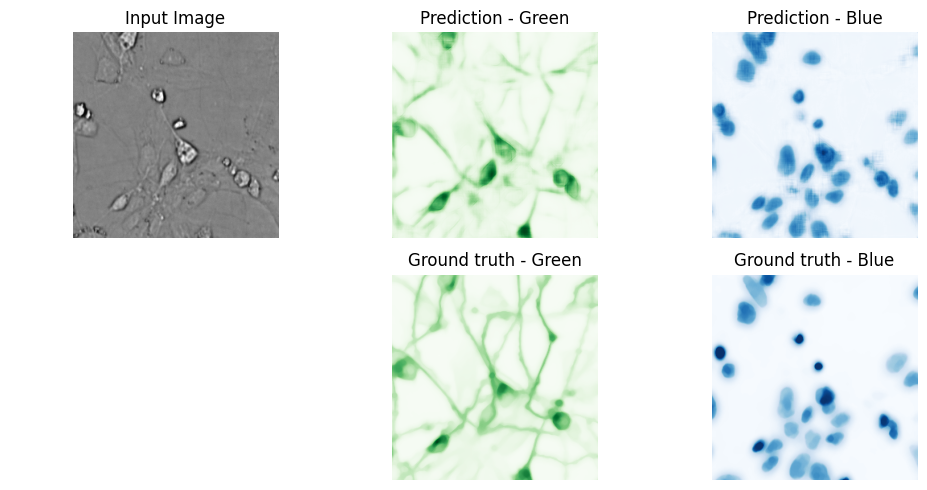

In [15]:
import time
from datetime import timedelta

epochs, L1_Lambda, LPIPS_Lambda = 500, 100, 10

generator_losses = []
discriminator_losses = []
reconstruction_losses = []
perceptual_losses = []
for epoch in range(epochs + 1):
    start_time = time.time()
    
    print("\n" + f"Epoch {epoch + 1}/{epochs}" + "\n" + "-" * 10)

    gen_loss_epochs = []
    disc_loss_epochs = []
    recon_loss_epochs = []
    percep_loss_epochs = []
    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        # 1. Train the discriminator.
        disc_loss = train_discriminator(
            inputs=inputs, 
            targets=labels, 
            optimizer=discriminator_optimizer,
        )

        # 2. Train the generator.
        for _ in range(2):
            adv_loss, rec_loss, percep_loss = train_generator(
                inputs=inputs, 
                targets=labels, 
                optimizer=generator_optimizer, 
                L1_Lambda=L1_Lambda, 
                LPIPS_Lambda=LPIPS_Lambda,
            )

        gen_loss = adv_loss + rec_loss + percep_loss
        
        if i % 5 == 0:
            print(f"Batch {i+1}/{len(train_loader)} : "
                  + f"Generator Loss: {gen_loss.item():.4f}, "
                  + f"Discriminator Loss: {disc_loss.item():.4f}")
        
        gen_loss_epochs.append(adv_loss.item())
        disc_loss_epochs.append(disc_loss.item())
        recon_loss_epochs.append(rec_loss.item())
        percep_loss_epochs.append(percep_loss.item())

    end_time = time.time()

    print("-" * 10 + "\n" + f"Epoch {epoch + 1}/{epochs} : "
          + f"Generator loss: {np.mean(gen_loss_epochs):.4f}, "
          + f"Discriminator Loss: {np.mean(disc_loss_epochs):.4f}, "
          + f"Reconstruction Loss: {np.mean(recon_loss_epochs):.4f}, "
          + f"Perception Loss: {np.mean(percep_loss_epochs):.4f}"
          + "\n" f"Time taken: {timedelta(seconds=end_time - start_time)}")

    if epoch % 50 == 0:
        for i, data, in enumerate(test_loader, 0):
            test_inputs, test_labels = data
            test_inputs = test_inputs.to(device)
            test_labels = test_labels.to(device)
            break
        evaluate_model(test_inputs, test_labels)
    
    generator_losses.append(np.mean(gen_loss_epochs))
    discriminator_losses.append(np.mean(disc_loss_epochs))
    reconstruction_losses.append(np.mean(recon_loss_epochs))
    perceptual_losses.append(np.mean(percep_loss_epochs))

## Evaluating the Trained Conditional GAN

Plot the various losses during training ...

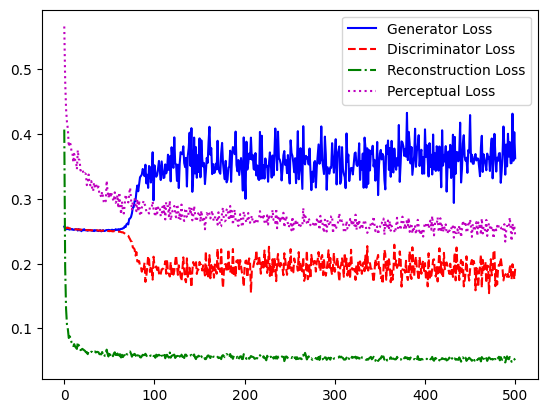

In [16]:
plt.figure()
plt.plot(generator_losses, "b-", label="Generator Loss")
plt.plot(discriminator_losses, "r--", label="Discriminator Loss")
plt.plot(reconstruction_losses, "g-.", label="Reconstruction Loss")
plt.plot(perceptual_losses, "m:", label="Perceptual Loss")
plt.legend()
plt.show()

... and determine the SSIM score.

In [17]:
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM

ssim_score = SSIM(data_range=2).to(device)

for i, (test_inputs, test_labels) in enumerate(test_loader, 0):
    test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)

    with torch.no_grad():
        ssim_green_channel = ssim_score(
            generator(test_inputs)[:, 1, :, :].unsqueeze(1),
            test_labels[:, 1, :, :].unsqueeze(1),
        ).item()
        print(f"SSIM Green Channel: {ssim_green_channel:.4f}")
        
        ssim_blue_channel = ssim_score(
            generator(test_inputs)[:, 2, :, :].unsqueeze(1),
            test_labels[:, 2, :, :].unsqueeze(1),
        ).item()
        print(f"SSIM Blue Channel: {ssim_blue_channel:.4f}")
        
        ssim_full_image = ssim_score(
            generator(test_inputs), 
            test_labels
        ).item()
        print(f"SSIM Full Image: {ssim_full_image:.4f}")

SSIM Green Channel: 0.6736
SSIM Blue Channel: 0.7975
SSIM Full Image: 0.8237
SSIM Green Channel: 0.6478
SSIM Blue Channel: 0.7389
SSIM Full Image: 0.7955
